# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Aldo Miguel Arroyo Castro
+ Juan Luis Vicente Bórquez Ormeño

**Correos Electrónicos:**

+ ald.arroyo@duocuc.cl
+ jua.borquez@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.11.10 y TensorFlow 2.15.1.

# Introducción

En este proyecto, se evaluaron diversos modelos de redes neuronales feedforward para abordar el problema de clasificación de un conjunto de datos. Se probaron distintas configuraciones, optimizadores, funciones de activación, tamaños de batch y técnicas como dropout, con el objetivo de analizar el impacto de estos factores en el rendimiento del modelo.

A lo largo del notebook, se realizaron experimentos con la implementación de redes neuronales de diferentes arquitecturas y se compararon sus resultados mediante métricas clave como la "accuracy" y la pérdida en los conjuntos de entrenamiento y prueba. Se incluyó la evaluación de diferentes optimizadores como SGD con momentum y ADAM, el ajuste de hiperparámetros como el learning rate y el tamaño del batch, y el análisis de la inclusión de capas adicionales y la función de activación tanh.

Además, se hicieron comparaciones entre modelos para identificar cuál generaba el mejor desempeño en términos de precisión y capacidad de generalización. Las métricas se visualizaron mediante gráficos y tablas para proporcionar una comparación clara y detallada entre las distintas configuraciones.

Este análisis busca proporcionar una visión completa de cómo la arquitectura de redes feedforward y el ajuste de sus parámetros pueden influir en su rendimiento, optimizando así el proceso de modelado para tareas de clasificación.










# Carga de datos y preprocesamiento de datos

In [1]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import pandas as pd
import sys
import os

from tensorflow.keras.models import load_model
from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

2025-04-21 02:45:15.451296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 02:45:15.451878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 02:45:15.453062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 02:45:15.459522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 02:45:16.934517: W tensorflow/compiler/tf2

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Python version:", sys.version)

TensorFlow Version: 2.15.1
Python version: 3.11.10 (main, Feb 13 2025, 15:40:15) [GCC 10.2.1 20210110]


In [3]:
if (os.path.exists("train-images-idx3-ubyte.gz") and os.path.exists("train-labels-idx1-ubyte.gz") and os.path.exists("t10k-images-idx3-ubyte.gz") and os.path.exists("t10k-labels-idx1-ubyte.gz")):
    print("Datasets already downloaded")
else:
    !rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


Datasets already downloaded


In [4]:
!ls -lh | grep 'gz'

-rw-r--r--. 1 root users 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r--. 1 root users 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz.1
-rw-r--r--. 1 root users 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r--. 1 root users 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz.1
-rw-r--r--. 1 root users 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r--. 1 root users 9.5M Apr  6  2017 train-images-idx3-ubyte.gz.1
-rw-r--r--. 1 root users  29K Apr  6  2017 train-labels-idx1-ubyte.gz
-rw-r--r--. 1 root users  29K Apr  6  2017 train-labels-idx1-ubyte.gz.1


In [5]:
os.makedirs("models", exist_ok=True)
print(f"Folder models created (or already exists).")

Folder models created (or already exists).


## Funciones

En esta sección se definen función que serán de utilidad en el resto de este jupyter notebook

### compare_history_metrics_grid

Función que toma el historial de los entrenamiento y devuelve resultado como df 

In [6]:
def compare_history_metrics_grid(hist1, hist2, name1="Modelo 1", name2="Modelo 2", title="Comparación de métricas finales"):
    # Obtener nombres de métricas de validación
    metric_keys = [k for k in hist1.history.keys() if k.startswith('val_')]

    values1 = []
    values2 = []
    labels = []

    for key in metric_keys:
        val1 = hist1.history[key][-1]
        val2 = hist2.history[key][-1]

        # Convertir a array y promediar si es necesario
        val1 = np.array(val1)
        val2 = np.array(val2)

        if val1.ndim > 0:
            val1 = val1.mean()
        if val2.ndim > 0:
            val2 = val2.mean()

        values1.append(val1)
        values2.append(val2)

        # Usar el nombre de la métrica sin "val_" para mostrar
        labels.append(key.replace("val_", "").capitalize())

    # Tamaño dinámico de la grilla
    cols = 2
    rows = (len(labels) + 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    axs = axs.flatten()

    for i in range(len(labels)):
        axs[i].bar([name1, name2], [values1[i], values2[i]], color=['khaki', 'orchid'])
        axs[i].set_title(labels[i])
        axs[i].set_ylim(0, max(values1[i], values2[i]) + 0.1)
        for j, v in enumerate([values1[i], values2[i]]):
            axs[i].yaxis.grid(True, linestyle='-', alpha=0.6) 
            axs[i].text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom')

    # Ocultar subplots vacíos si sobran
    for j in range(len(labels), len(axs)):
        axs[j].axis('off')

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### extraer_info_redes

Función que extrae los hiperparametros de las redes

In [7]:
def extraer_info_redes(nombres_redes):
    data = []

    for nombre_red in nombres_redes:
        modelo = globals()[nombre_red]  # Accede a la red por su nombre en string

        # Nombre
        nombre = modelo.name

        # Función de activación (busca la capa con atributo 'activation')
        funcion_activacion = "N/A"
        for capa in modelo.layers:
            if hasattr(capa, 'activation'):
                funcion_activacion = capa.activation.__name__
                break

        # Dropout rate si hay alguna capa Dropout
        dropout_rate = 0
        for capa in modelo.layers:
            if isinstance(capa, keras.layers.Dropout):
                dropout_rate = capa.rate
                break

        # Optimizador
        optimizador = modelo.optimizer.__class__.__name__

        # Learning rate
        learning_rate = float(modelo.optimizer.learning_rate.numpy())
        learning_rate = round(learning_rate, 4)

        # Agregar a la tabla
        data.append([nombre, funcion_activacion, dropout_rate, optimizador, learning_rate])

    # Mostrar como tabla
    df = pd.DataFrame(data, columns=["Nombre Red", "Función de Activación", "Tasa de Dropout", "Optimizador", "Learning Rate"])
    return df

### plot_accuracy_bars

Función que entrega un grafico de barras de los "accuracy" del historial de los modelos 

In [8]:
def plot_accuracy_bars(history, titulo="Accuracy por época", sub_titulo="", ax=None):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)
    bar_width = 0.4

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    min_acc = min(min(train_acc), min(val_acc))
    y_min = max(min_acc - 0.02, 0)  # límite inferior para el eje y

    # Crear el eje si no se proporciona
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_acc, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_acc, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_acc[i] + 0.001, f"{train_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_acc[i] + 0.001, f"{val_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_acc, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_acc, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, 1.0)
    ax.legend()
    ax.grid(True, axis='y')


###  plot_loss_bars

Función que entrega un grafico de barras de la perdida del historial de los modelos

In [9]:
def plot_loss_bars(history, titulo="Pérdida por época", sub_titulo="", ax=None):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)
    bar_width = 0.4

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    min_loss = min(min(train_loss), min(val_loss))
    max_loss = max(max(train_loss), max(val_loss))
    y_min = max(min_loss - 0.02, 0)  # límite inferior para el eje y
    y_max = min(max_loss + 0.02, 1.0)  # límite superior para el eje y

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_loss, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_loss, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_loss[i] + 0.001, f"{train_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_loss[i] + 0.001, f"{val_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_loss, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_loss, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True, axis='y')

###  plot_execution_times

Función que entrega un grafico tiempo de ejecución de los modelos

In [10]:
def plot_execution_times(tiempos, modelos = ['Sin Dropout', 'Con Dropout'], colores = ['skyblue', 'lightgreen'], titulo="Tiempo de Ejecución", sub_titulo=""):
    fig, ax = plt.subplots(figsize=(8, 4))

    # Crear las barras con colores distintos
    bars = ax.barh(modelos, tiempos, color=colores, label='Tiempo de Ejecución (segundos)')

    # Agregar los valores al final de cada barra
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                va='center', fontsize=12)

    # Etiquetas y formato
    ax.set_xlabel('Tiempo de Ejecución (segundos)')
    ax.set_ylabel('Modelo')
    ax.set_title(f'{titulo}\n{sub_titulo}')
    ax.grid(True, axis='x')

    plt.tight_layout()
    plt.show()

### generate_metrics_table_from_histories

Genera una tabla con las métricas de los modelos entregados

In [11]:
def generate_metrics_table_from_histories(models):
    # Chequear que sea una lista
    if not isinstance(models, list):
        models = [models]
        single_model = True
    else:
        single_model = len(models) == 1

    results = []
    for hist in models:
        final_epoch = {}
        for metric, values in hist.history.items():
            # Extraer el valor escalar de la última época
            last_value = values[-1]
            if isinstance(last_value, (list, np.ndarray)):
                last_value = np.mean(last_value)  # O puedes usar last_value[-1] si prefieres solo la última clase
            final_epoch[metric] = last_value
        result = {"Modelo": hist.name, **final_epoch}
        results.append(result)

    results_df = pd.DataFrame(results)

    if single_model:
        results_df = results_df.drop(columns="Modelo")

    return results_df

# Carga de imágenes

El conjunto de datos MNIST (Modified National Institute of Standards and Technology) es una base de imágenes ampliamente utilizada en tareas de clasificación. Contiene dígitos escritos a mano del 0 al 9, representados en imágenes en escala de grises de 28x28 píxeles. El dataset está compuesto por 60.000 imágenes para entrenamiento y 10.000 para prueba, cada una etiquetada con el número correspondiente. Es una herramienta estándar en el aprendizaje automático para evaluar modelos de reconocimiento de patrones. En Keras, puede cargarse fácilmente mediante su API integrada, que gestiona la descarga y preparación del conjunto de manera automática.

In [12]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


In [13]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Muestra imágenes

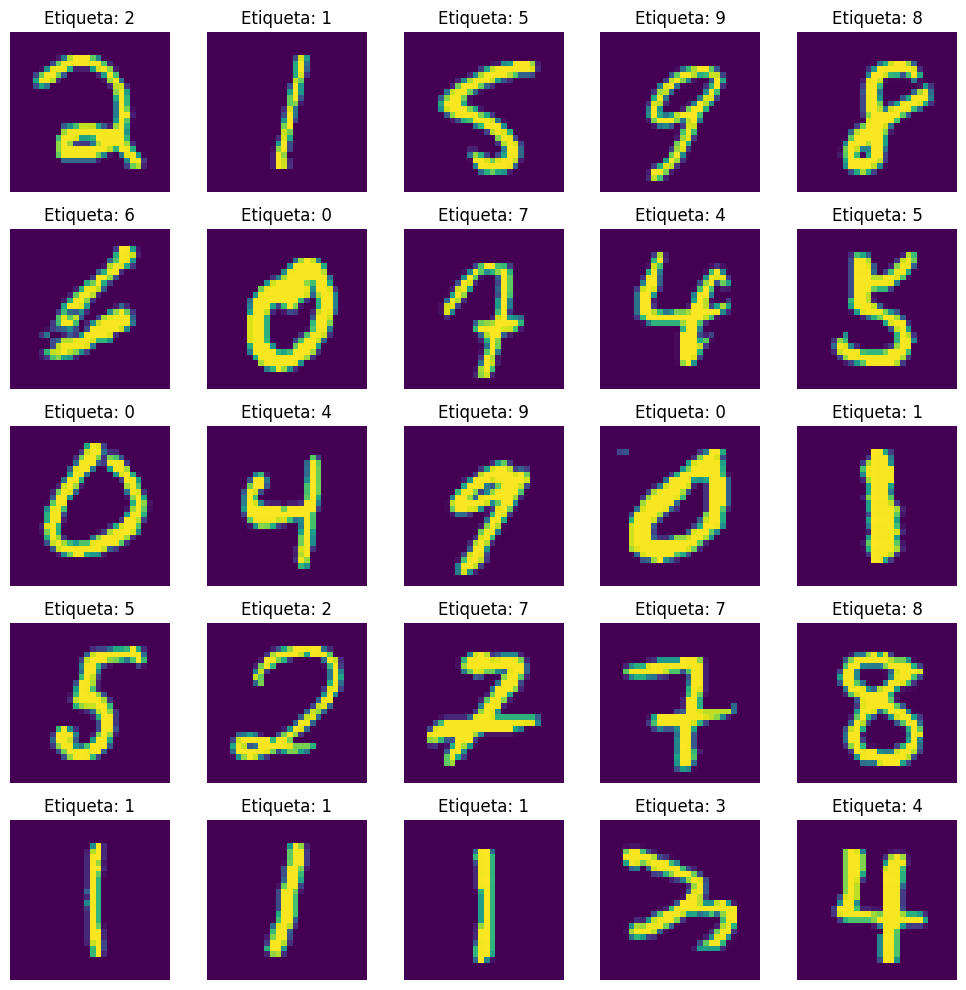

In [14]:
h = 5  # alto de la grilla
w = 5  # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(2*w, 2*h))

for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_test))
        axs[i, j].imshow(X_test[ex].reshape(28, 28))
        axs[i, j].set_title(f"Etiqueta: {np.argmax(y_test[ex])}")
        axs[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

# Balance de clases

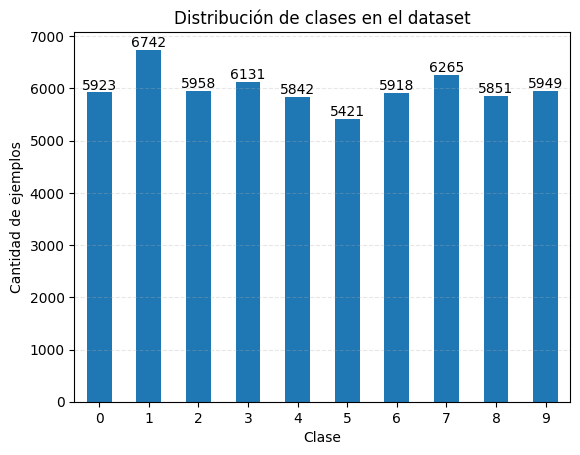

In [15]:
y_train_raw = np.argmax(y_train, axis=1)

df_balance = pd.DataFrame({"label": y_train_raw})

counts = df_balance['label'].value_counts().sort_index()

ax = counts.plot(kind='bar')

for i, value in enumerate(counts):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xlabel("Clase")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el dataset")
plt.grid(axis='y', linestyle="--", alpha=0.3)
plt.xticks(rotation=0)
plt.show()

Se observa una asimetría en los datos. La clase 5 tiene la menor cantidad de muestras, lo que podría afectar negativamente el rendimiento del modelo al evaluar esta clase. Por otro lado, la clase 1 tiene la mayor cantidad de muestras, lo que podría generar un sesgo en los modelos hacia predecir este número con mayor frecuencia. Dependiendo del rendimiento de los modelos, podría ser necesario aplicar técnicas como el ajuste de pesos o el sobremuestreo.

# Definición de los modelos


Se implementaron redes neuronales de tipo perceptrón multicapa (MLP) con arquitectura feedforward, integrando funciones de activación, técnicas de regularización como Dropout, y utilizando dos algoritmos de optimización diferentes. En particular, se evaluaron los optimizadores SGD con momentum y Adam, con el objetivo de comparar su desempeño durante el entrenamiento del modelo.

In [16]:
M_train = X_train.shape[0]
M_test = X_test.shape[0]

N = X_train.shape[1]
C = y_train.shape[1]

print(N, C, M_train, M_test)

784 10 60000 10000


# Optimizador: SGD + Momentum

## Definición del modelo base con 2 capas ocultas (SGD + Momentum):

Se implementó un modelo base de red neuronal feedforward utilizando el optimizador SGD con momentum (0.9) y una tasa de aprendizaje de 0.01. El modelo está compuesto por dos capas ocultas: la primera con 128 neuronas y la segunda con 64 neuronas, configuraciones comunes para conjuntos de datos con baja variabilidad y estructura sencilla. Ambas capas emplean la función de activación ReLU. La capa de salida utiliza la función softmax, adecuada para tareas de clasificación multiclase. El entrenamiento se realizó durante 10 épocas con un tamaño de batch de 128, utilizando la función de pérdida categorical_crossentropy y métricas como precisión, recall, F1-score y exactitud.

Este modelo actúa como punto de partida sobre el cual se realizarán modificaciones en los hiperparámetros (como número de capas, regularización, optimizadores, entre otros) con el fin de evaluar mejoras en el rendimiento.

### Consideraciones

Se utilizó la función de pérdida categorical_crossentropy porque el problema es de clasificación multiclase y las etiquetas están en formato one-hot encoding, lo que significa que cada clase está representada por un vector con un 1 en la posición correspondiente y ceros en las demás. Esta función de pérdida es adecuada para este tipo de representación. Debido a esto, se mantuvo categorical_crossentropy en todas las variantes del modelo, ya que es la opción correcta para este tipo de clasificación.

In [17]:
# Lista de historiales de los modelos SGD + Momentum
hist_models = []

### Creación y ejecución de modelo

In [18]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd = keras.Sequential(name="MLP_sgd")
red_sgd.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [19]:
time_start = time.time()
hist_sgd = red_sgd.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0 # No mostrar resultados en pantalla
        )
time_sgd = time.time() - time_start

hist_sgd.name = red_sgd.name
hist_models.append(hist_sgd)

red_sgd.save("./models/red_sgd.keras")

2025-04-21 02:45:21.713161: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


### Gráficos de barra con métricas

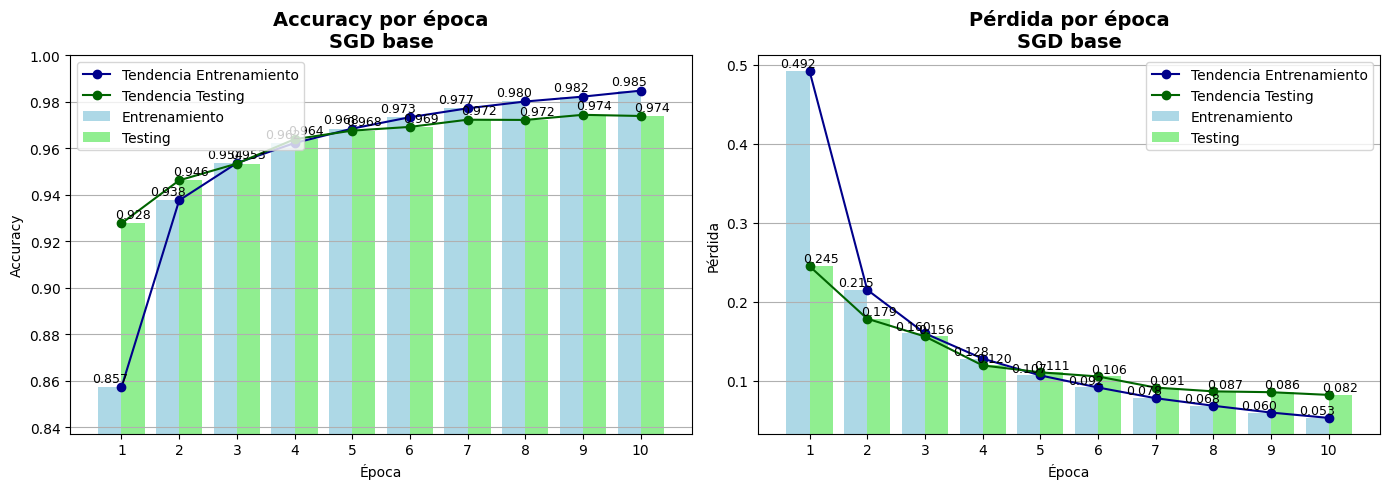

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[1])

plt.tight_layout()
plt.show()

Se observa que el modelo alcanza un cierto equilibrio en su "accuracy" a partir de la época 7, manteniéndose relativamente constante desde ese punto. En cuanto a la pérdida, el último gran salto en rendimiento se produce en la época 6; a partir de ahí, la mejora es continúa y de forma leve hasta la época 10. En general, la evolución del rendimiento a lo largo de las épocas es estable, sin fluctuaciones erráticas, salvo el incremento más pronunciado que ocurre entre la época 1 y la 2.

### Tabla con métricas

In [21]:
generate_metrics_table_from_histories(hist_sgd)

,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,0.053072,0.9848,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.971,0.973623


In [22]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045


### Evaluación modelo base

Se puede observar que, a pesar de tener una arquitectura básica, el modelo presenta un rendimiento muy bueno. Esto puede deberse a la naturaleza del dataset MNIST, el cual no presenta un desbalance significativo entre clases ni una alta dimensionalidad, lo que permite que una red simple sea suficiente.

## Learning rate

A partir del modelo base con optimizador SGD + momentum, se realizó una modificación ajustando el learning rate a 0.05 (desde 0.01). Esta variación permite evaluar cómo afecta la tasa de aprendizaje al desempeño del modelo durante el entrenamiento.

### Creación y ejecución de modelo

Definición de la arquitectura

In [23]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn = keras.Sequential(name="MLP_sgd_l005")
red_sgd_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Entrenamiento de la red

In [24]:
time_start = time.time()
hist_sgd_learn = red_sgd_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_learn = time.time() - time_start

hist_sgd_learn.name = red_sgd_learn.name
hist_models.append(hist_sgd_learn)

red_sgd_learn.save("./models/red_sgd_l005.keras")

2025-04-21 02:45:34.710239: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


### Gráficos de barra con métricas

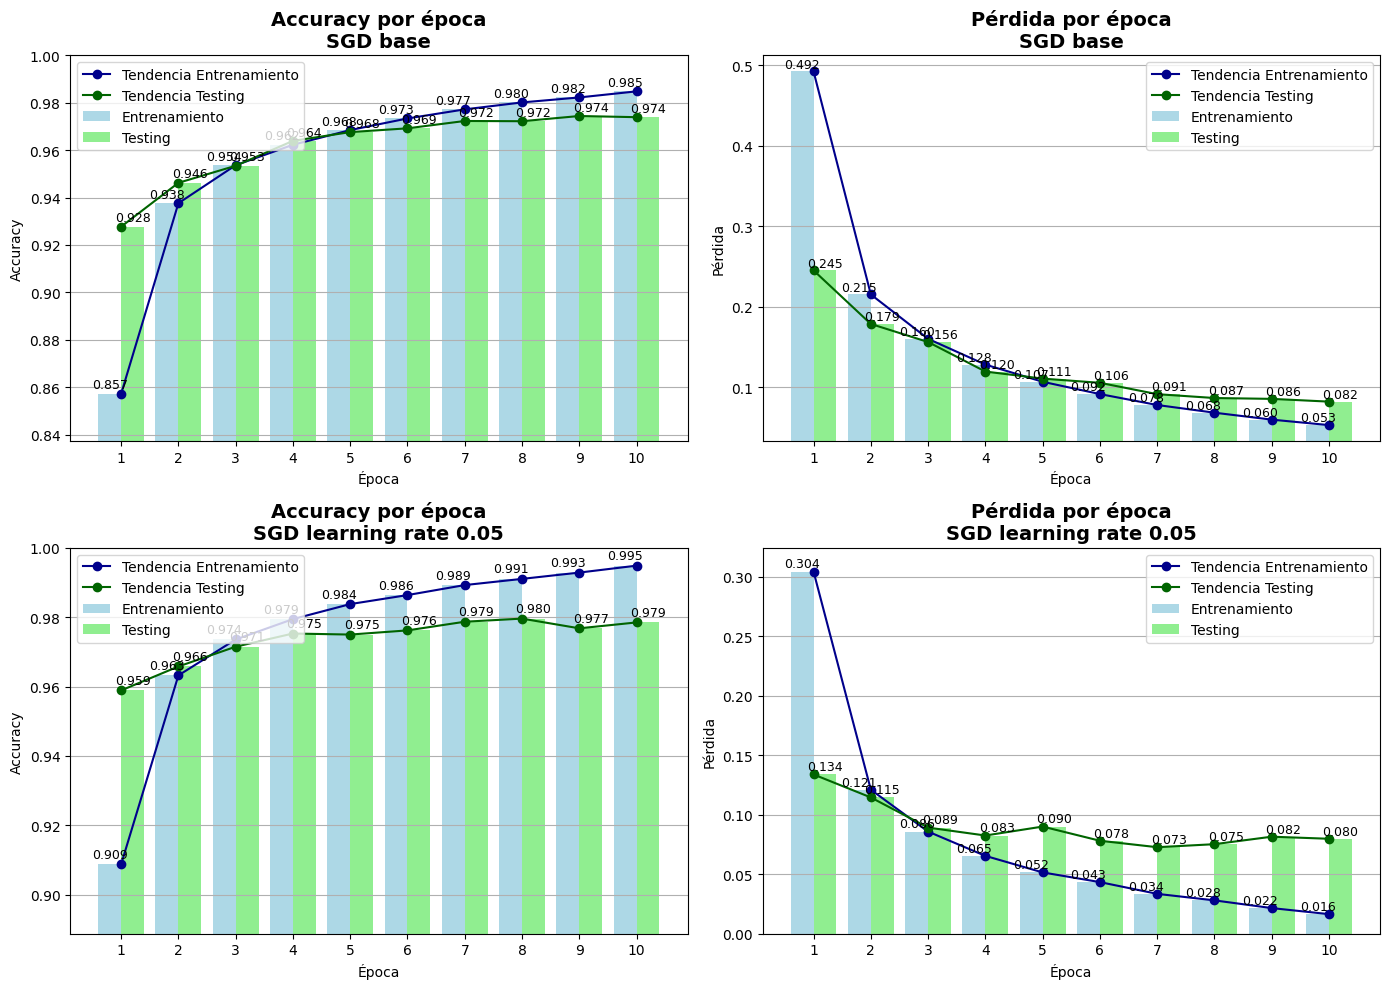

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_sgd
plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 1])

# Segundo modelo: hist_sgd_learn
plot_accuracy_bars(hist_sgd_learn, sub_titulo="SGD learning rate 0.05", ax=axes[1, 0])
plot_loss_bars(hist_sgd_learn, sub_titulo="SGD learning rate 0.05", ax=axes[1, 1])

plt.tight_layout()
plt.show()

En el gráfico correspondiente al modelo con una tasa de aprendizaje de 0.05, se aprecia un aumento progresivo en la diferencia entre los resultados del conjunto de entrenamiento y los del conjunto de prueba a lo largo de las épocas, lo que sugiere la presencia de un posible sobreentrenamiento.

### Tabla con métricas

In [26]:
generate_metrics_table_from_histories([hist_sgd, hist_sgd_learn])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_sgd_l005,0.016454,0.994867,0.995346,0.994450,0.994862,0.079825,0.9785,0.980052,0.9777,0.978287


### Tiempo de ejecución comparado con el mejor modelo anterior 

In [27]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_sgd_learn: {time_sgd_learn}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_sgd_learn)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_sgd_learn: 11.767438173294067
Porcentaje de mejora/empeoramiento: 0.54%


Al aplicar la nueva tasa de aprendizaje, el tiempo de ejecución presenta un aumento muy leve, por lo que no representa una justificación válida para descartar este modelo como opción.

### Evaluación del modelo con learning rate = 0.05

Se puede observar que, al aumentar la tasa de aprendizaje, el "accuracy" del modelo mejora levemente y la pérdida disminuye ligeramente. Sin embargo, la diferencia entre los resultados obtenidos en los conjuntos de entrenamiento y prueba se incrementa de forma considerable, lo que podría indicar la presencia de overfitting. Esto sugiere que el modelo no generaliza tan bien como la versión base. Por esta razón, se decide mantener la tasa de aprendizaje original del modelo base (0.01).

## Aumento de capas

A partir del modelo con learning rate 0.05, se aumentó la profundidad de la red a 4 capas ocultas. Esta modificación permite evaluar el impacto del número de capas en el desempeño del modelo.

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [28]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 4 capas escondidas

h1 = 128
h2 = 64

red_sgd_layers = keras.Sequential(name="MLP_sgd_c4")
red_sgd_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_sgd_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_layers.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [29]:
time_start = time.time()
hist_sgd_layers = red_sgd_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_layers = time.time() - time_start

hist_sgd_layers.name = red_sgd_layers.name
hist_models.append(hist_sgd_layers)

red_sgd_layers.save("./models/red_sgd_c4.keras")

2025-04-21 02:45:48.209427: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


### Gráficos de barra con métricas

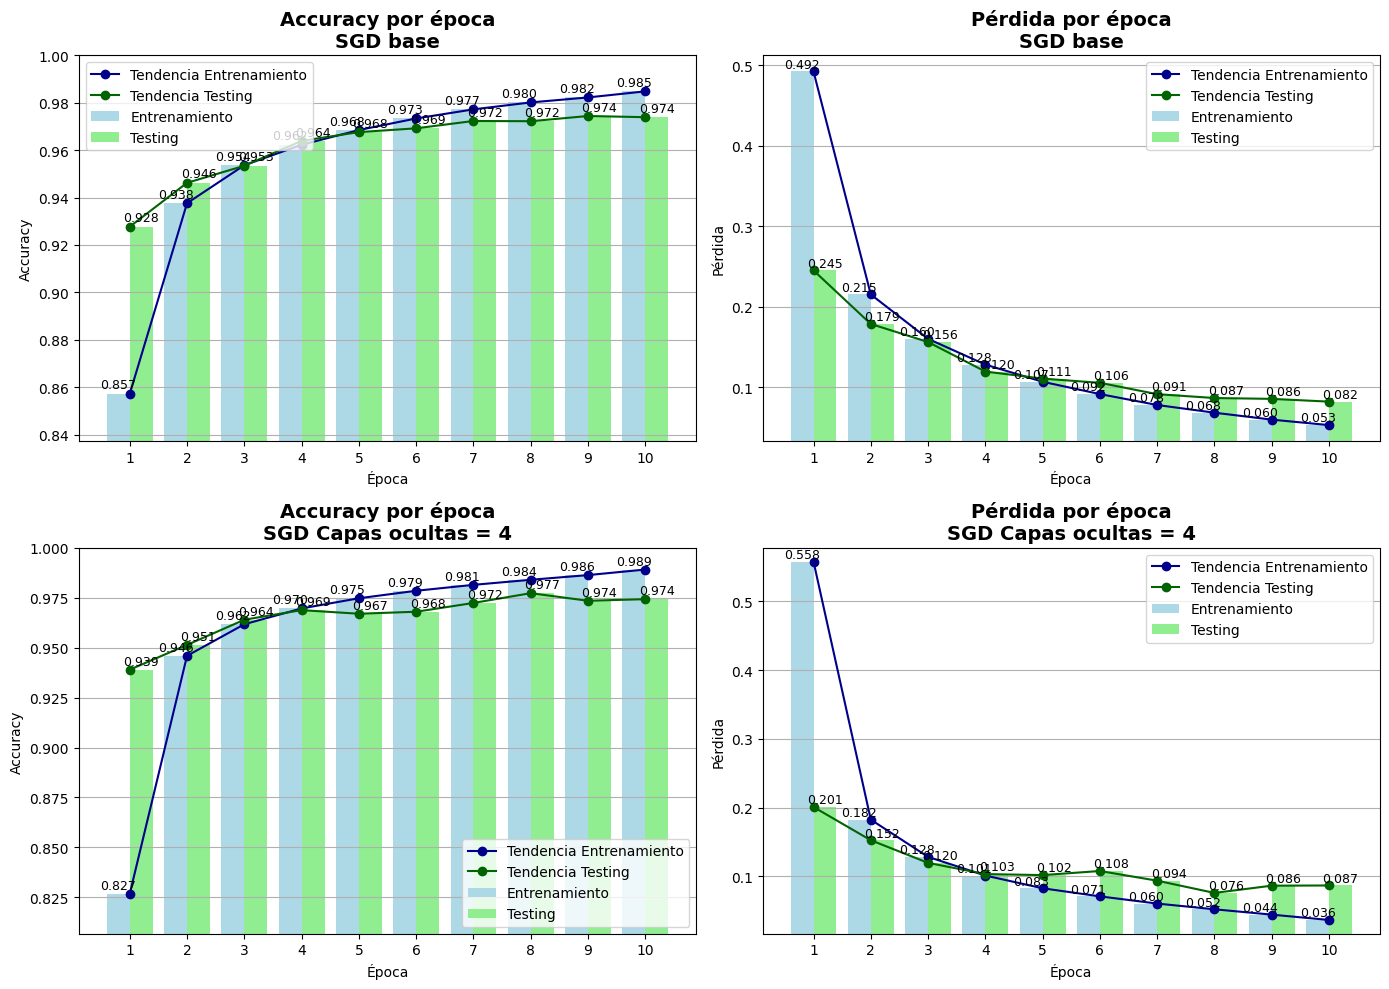

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_sgd
plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 1])

# Segundo modelo: hist_sgd_layers
plot_accuracy_bars(hist_sgd_layers, sub_titulo="SGD Capas ocultas = 4", ax=axes[1, 0])
plot_loss_bars(hist_sgd_layers, sub_titulo="SGD Capas ocultas = 4", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Al aumentar el número de capas, se observa una ligera mejora en la precisión (accuracy) en la mayoría de las épocas, junto con un aumento en la pérdida. Además, se evidencia una mayor diferencia entre los resultados obtenidos en los conjuntos de entrenamiento y prueba.

### Tabla con métricas

In [31]:
generate_metrics_table_from_histories([hist_sgd, hist_sgd_layers])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_sgd_c4,0.036431,0.989133,0.990359,0.987883,0.989050,0.086621,0.9743,0.976597,0.9723,0.973987


### Tiempo de ejecución comparado con el mejor modelo anterior

In [32]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_sgd_layers: {time_sgd_layers}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_sgd_layers)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_sgd_layers: 12.723244190216064
Porcentaje de mejora/empeoramiento: -7.54%


Al aplicar la cuatro capas, el tiempo de ejecución presenta un aumento levemente significativo , por lo que podría presentar una justificación válida para descartar este modelo como opción.

### Evaluación del modelo con cuatro capas

Los resultados muestran que el modelo generaliza levemente mejor con cuatro capas ocultas. Sin embargo, este aumento no justifica la mayor complejidad, ya que también incrementa ligeramente la diferencia entre los resultados obtenidos en los conjuntos de entrenamiento y prueba. Por lo tanto, se opta por mantener el número de capas ocultas en dos.

## Función de activación tanh

A partir del modelo con SGD, y 2 capas ocultas, se modificó la función de activación pasando de ReLU a tanh. Esta variante busca evaluar cómo el tipo de activación influye en el rendimiento manteniendo el resto de la arquitectura constante.

### Creación y ejecución de modelo

In [33]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)

# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_act = keras.Sequential(name="MLP_sgd_actTanh")
red_sgd_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_sgd_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_sgd_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_act.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [34]:
time_start = time.time()
hist_sgd_act = red_sgd_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_act = time.time() - time_start

hist_sgd_act.name = red_sgd_act.name
hist_models.append(hist_sgd_act)

red_sgd_act.save("./models/red_sgd_actTanh.keras")

2025-04-21 02:46:02.554383: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


### Gráficos de barra con métricas

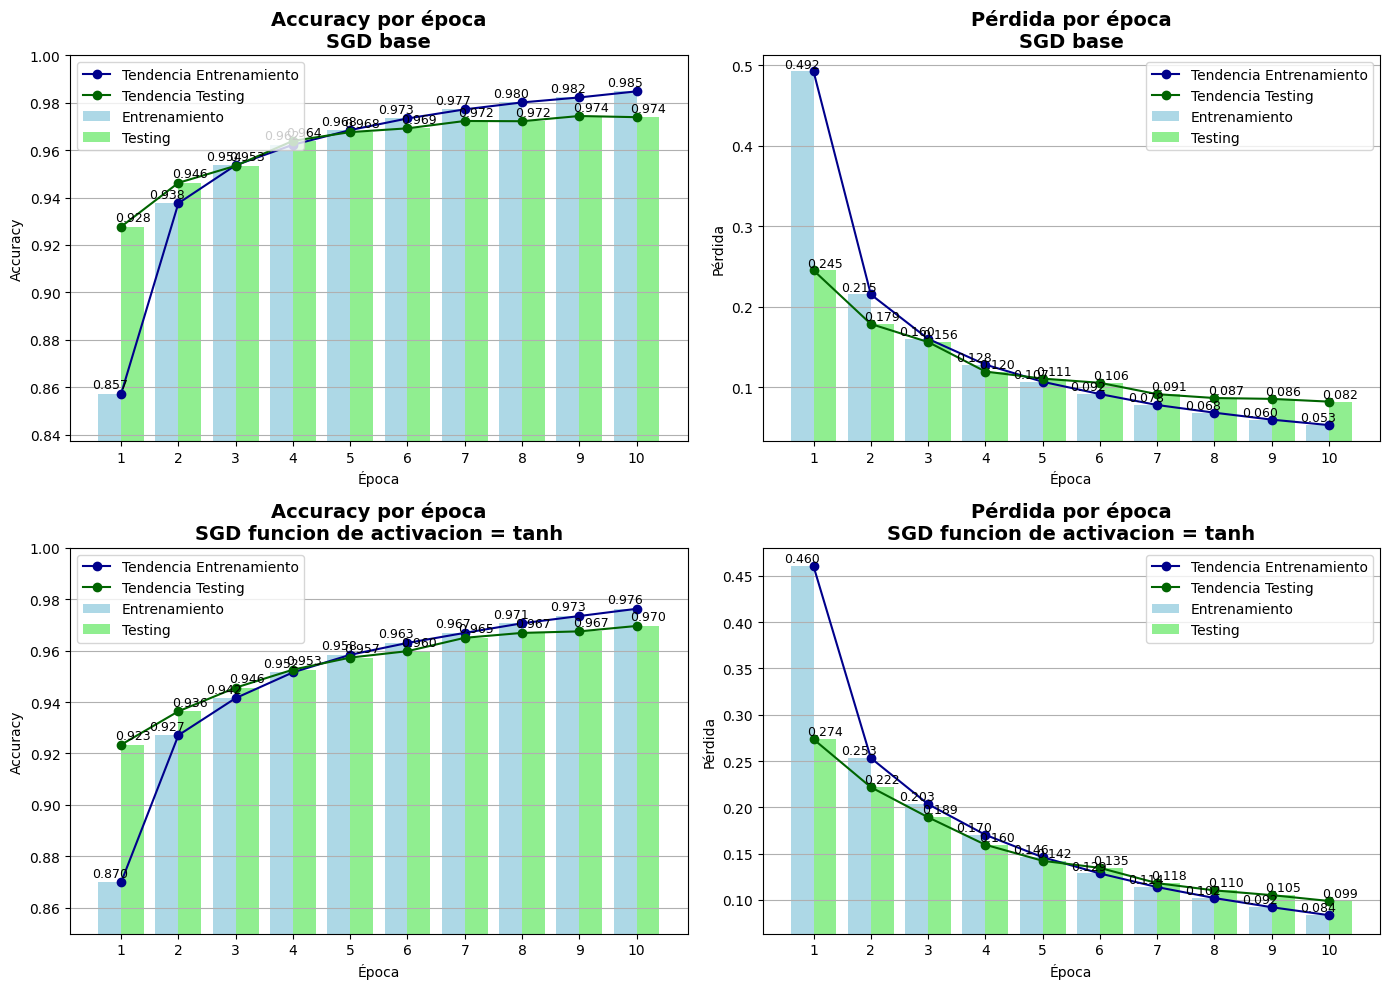

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_sgd
plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 1])

# Segundo modelo: hist_sgd_act
plot_accuracy_bars(hist_sgd_act, sub_titulo="SGD funcion de activacion = tanh", ax=axes[1, 0])
plot_loss_bars(hist_sgd_act, sub_titulo="SGD funcion de activacion = tanh", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Se observa que, al utilizar la nueva función de activación (tanh), el rendimiento del modelo se mantiene bastante similar a lo largo de las épocas, y se reduce levemente la diferencia entre los resultados de los conjuntos de entrenamiento y prueba.

### Tabla con métricas

In [36]:
generate_metrics_table_from_histories([hist_sgd, hist_sgd_act])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_sgd_actTanh,0.083522,0.976283,0.981412,0.971467,0.976136,0.098874,0.9696,0.975361,0.9659,0.969422


### Tiempo de ejecución comparado con el mejor modelo anterior

In [37]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_sgd_act: {time_sgd_act}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_sgd_act)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_sgd_act: 12.707667827606201
Porcentaje de mejora/empeoramiento: -7.41%


Al aplicar la nueva función de activación (tanh), el tiempo de ejecución presenta una disminución demasiado leve, por lo que no representa una justificación válida para descartar este modelo como opción.

### Evaluación del modelo con función de activación tanh 

Se observa que, al modificar la función de activación a tanh, la precisión del modelo disminuye tanto en el conjunto de entrenamiento como en el de prueba. En cuanto a la pérdida, el rendimiento también empeora en ambos conjuntos. No obstante, la diferencia entre las métricas de entrenamiento y prueba se reduce levemente, lo que podría sugerir una mayor capacidad de generalización. Sin embargo, se opta por mantener el modelo base, ya que presenta un mejor rendimiento general, aunque con una diferencia ligeramente mayor entre los conjuntos.

## Tamaño de batch

A partir del modelo con SGD, 2 capas ocultas y función de activación tanh, se cambió el tamaño del batch de 128 a 32. Esta modificación permite evaluar cómo el tamaño del batch afecta el rendimiento y tiempo de entrenamiento del modelo.

### Creación y ejecución de modelo

In [38]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)

# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_batch = keras.Sequential(name="MLP_sgd_batch32")
red_sgd_batch.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_batch.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_batch.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [39]:
time_start = time.time()
hist_sgd_batch = red_sgd_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_batch = time.time() - time_start

hist_sgd_batch.name = red_sgd_batch.name
hist_models.append(hist_sgd_batch)

red_sgd_batch.save("./models/red_sgd_batch32.keras")

2025-04-21 02:46:16.999939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


### Gráficos de barra con métricas

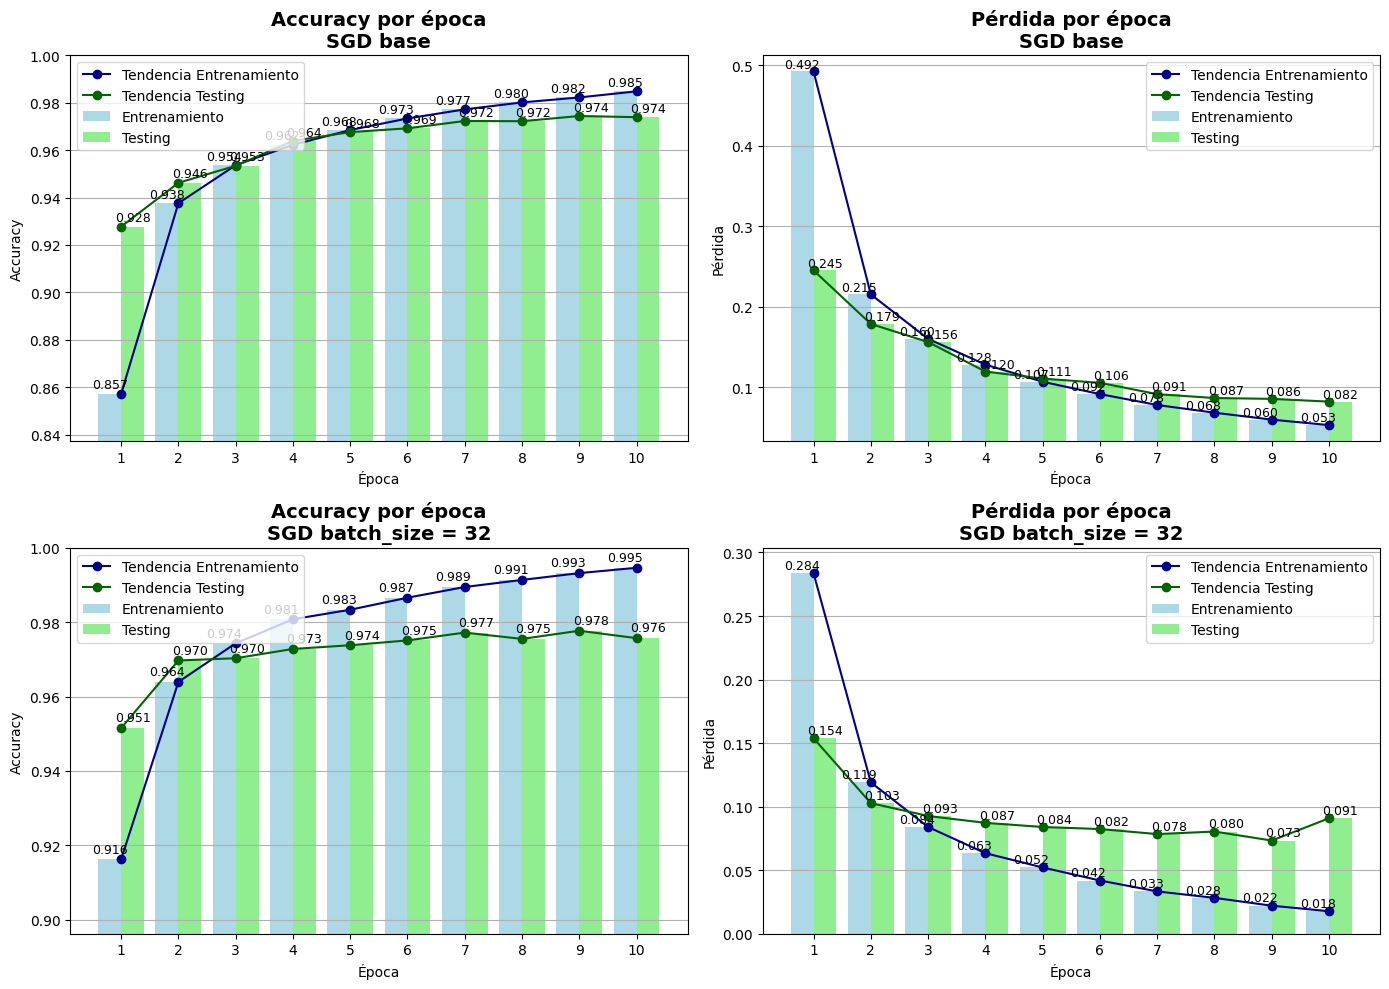

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_sgd
plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 1])

# Segundo modelo: hist_sgd_batch
plot_accuracy_bars(hist_sgd_batch, sub_titulo="SGD batch_size = 32", ax=axes[1, 0])
plot_loss_bars(hist_sgd_batch, sub_titulo="SGD batch_size = 32", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Se observa que al cambiar el tamaño del batch a 32, el modelo mejora tanto la precisión como la pérdida en ambos conjuntos de datos. Sin embargo, este ajuste introduce una diferencia considerable entre los resultados de los conjuntos de entrenamiento y prueba. Indicando un sobreentrenamiento

### Tabla con métricas

In [41]:
generate_metrics_table_from_histories([hist_sgd, hist_sgd_batch])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_sgd_batch32,0.017708,0.994633,0.995262,0.994267,0.994612,0.090839,0.9757,0.977441,0.9749,0.975408


### Tiempo de ejecución comparado con el mejor modelo anterior

In [42]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_sgd_batch: {time_sgd_batch}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_sgd_batch)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_sgd_batch: 41.67368984222412
Porcentaje de mejora/empeoramiento: -252.23%


Al aplicar un tamaño de batch menor, el tiempo de ejecución presenta un aumento bastante significativo, por lo que presenta una justificación válida para descartar este modelo como opción.

### Evaluación del modelo con tamaño de batch de 32

Se observa un incremento significativo en la diferencia entre los resultados obtenidos en los conjuntos de entrenamiento y prueba, lo que sugiere un posible overfitting. Por lo tanto, se recomienda mantener el tamaño de batch del modelo base (128). Además, el tiempo de entrenamiento aumenta considerablemente en comparación con los otros modelos.

## Dropout

A partir del modelo base (SGD + Momentum), se incorporó una capa de dropout con el objetivo de mitigar el leve desbalance de clases presente en los datos de entrenamiento. El dropout actúa como una técnica de regularización que reduce el sobreajuste, permitiendo que la red generalice mejor y no se incline excesivamente hacia las clases mayoritarias.

In [43]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_drop = keras.Sequential(name="MLP_sgd_drop0.3")
red_sgd_drop.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_drop.add(keras.layers.Dropout(0.3))
red_sgd_drop.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_drop.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [44]:
time_start = time.time()
hist_sgd_drop = red_sgd_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_drop = time.time() - time_start

hist_sgd_drop.name = red_sgd_drop.name
hist_models.append(hist_sgd_drop)

red_sgd_drop.save("./models/red_sgd_drop03.keras")

### Gráficos de barra con métricas

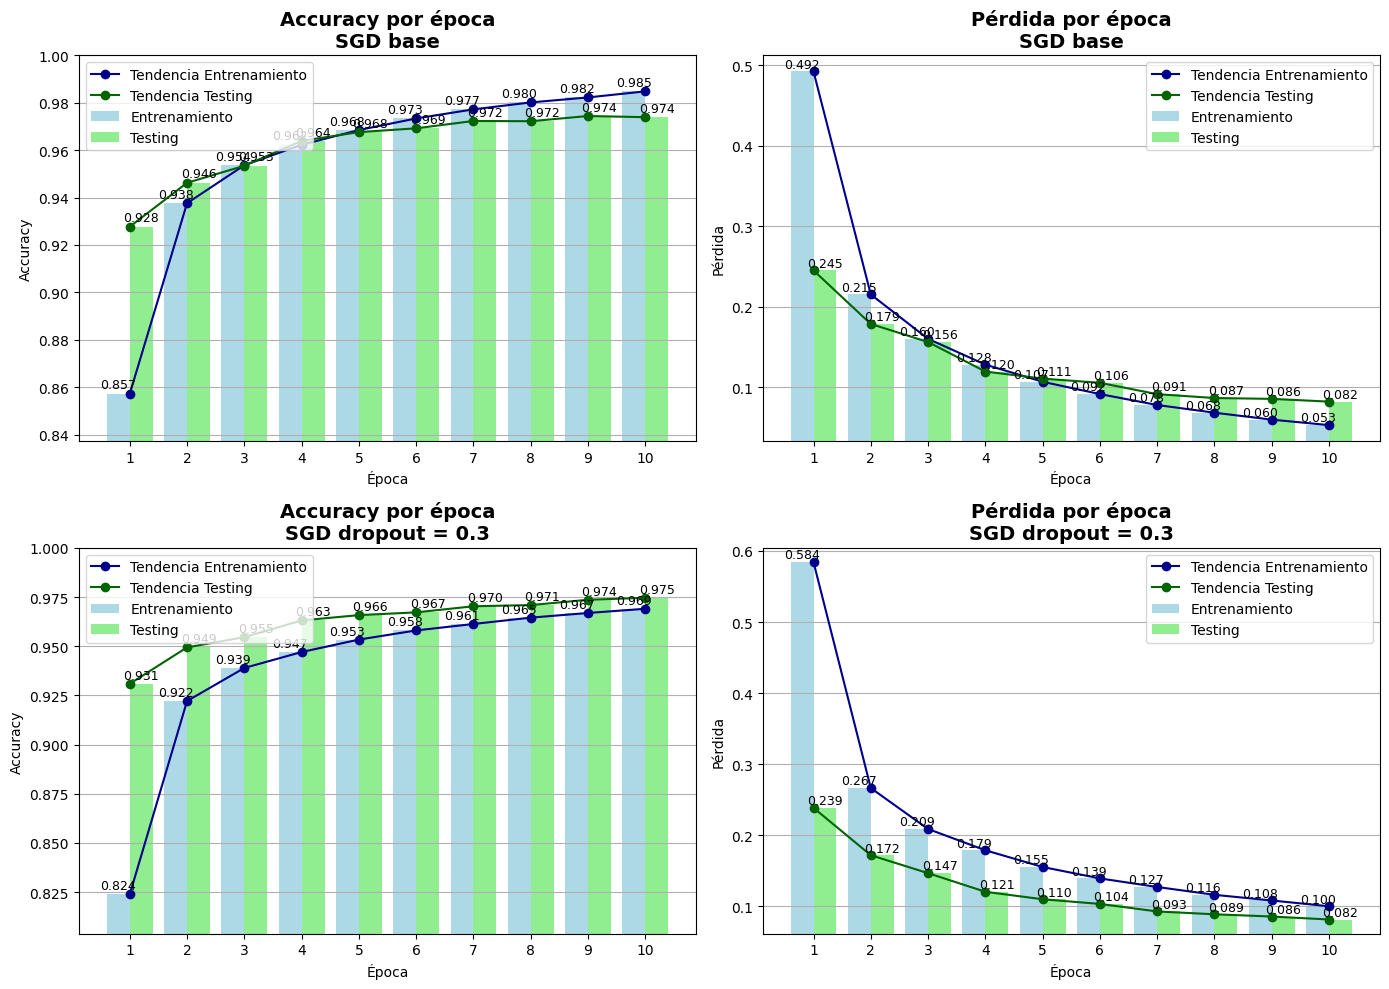

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_sgd
plot_accuracy_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 0])
plot_loss_bars(hist_sgd, sub_titulo="SGD base", ax=axes[0, 1])

# Segundo modelo: hist_sgd_drop
plot_accuracy_bars(hist_sgd_drop, sub_titulo="SGD dropout = 0.3", ax=axes[1, 0])
plot_loss_bars(hist_sgd_drop, sub_titulo="SGD dropout = 0.3", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Se observa un rendimiento inferior en el conjunto de entrenamiento a lo largo de todas las épocas en ambas métricas, acompañado de una leve mejora en la diferencia entre los resultados obtenidos en los conjuntos de entrenamiento y prueba.

### Tabla con métricas

In [46]:
generate_metrics_table_from_histories([hist_sgd, hist_sgd_drop])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_sgd_drop0.3,0.100239,0.969033,0.974145,0.963917,0.968804,0.081617,0.9746,0.978066,0.9721,0.974406


### Tiempo de ejecución comparado con el mejor modelo anterior

In [47]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_sgd_drop: {time_sgd_drop}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_sgd_drop)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_sgd_drop: 21.139797687530518
Porcentaje de mejora/empeoramiento: -78.68%


Al aplicar dropout al modelo, el tiempo de ejecución presenta un aumento bastante significativo, por lo que presenta una justificación válida para descartar este modelo como opción.

### Evaluación del modelo con dropout

Debido al impacto del dropout en el modelo, se observa un rendimiento inferior en el conjunto de entrenamiento en ambas métricas, en comparación con el conjunto de prueba, junto con una leve mejora en las diferencias, aunque estas no son significativas. Además, el tiempo de entrenamiento aumenta. Por lo tanto, se decide mantener el modelo base con SGD como la mejor opción.

# Optimizador: ADAM

## Definición del modelo base con 2 capas ocultas (Adam):

Se implementó un modelo base de red neuronal feedforward utilizando el optimizador Adam, con la función de pérdida categorical crossentropy. El modelo cuenta con dos capas ocultas, la primera con 128 neuronas y la segunda con 64 neuronas, ambas utilizando ReLU como función de activación. La capa de salida utiliza softmax, adecuada para tareas de clasificación multiclase. Se entrenó durante 10 épocas con un tamaño de batch de 128, evaluando el rendimiento mediante métricas como exactitud, precisión, recall y F1-score.

Este modelo sirve como punto de partida para posteriores experimentaciones, permitiendo analizar cómo distintas configuraciones e hiperparámetros impactan en el rendimiento del modelo.

In [48]:
hist_models_adam = []

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [49]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam = keras.Sequential(name="MLP_adam")
red_adam.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [50]:
time_start = time.time()
hist_adam = red_adam.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam = time.time() - time_start

hist_adam.name = red_adam.name
hist_models_adam.append(hist_adam)

red_adam.save("./models/red_adam.keras")

### Gráficos de barra con métricas

Visualización del "accuracy" y perdida por época de los modelos

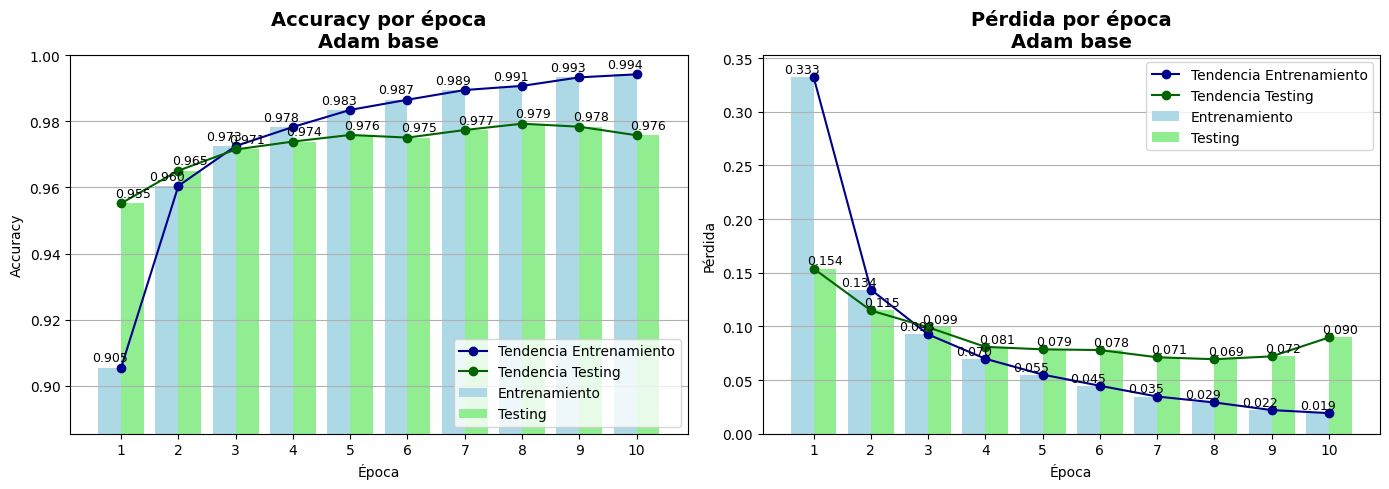

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_accuracy_bars(hist_adam, sub_titulo="Adam base", ax=axes[0])
plot_loss_bars(hist_adam, sub_titulo="Adam base", ax=axes[1])

plt.tight_layout()
plt.show()

Se observa una mejora constante en el "accuracy" del modelo tanto en entrenamiento como en validación durante las primeras épocas. A partir de la época 4, el accuracy comienza a estabilizarse en ambos conjuntos, indicando que el modelo ya ha aprendido lo suficiente y no presenta cambios muy grandes en las épocas siguientes. La pérdida disminuye de forma constante, con los mayores cambios en las primeras épocas. Desde la época 4, los valores se estabilizan y presentan solo ligeras variaciones, lo que indica un aprendizaje consistente del modelo.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [52]:
generate_metrics_table_from_histories(hist_adam)

,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,0.019201,0.99425,0.994876,0.993533,0.994237,0.089698,0.9758,0.976462,0.9749,0.975603


In [53]:
print(f"Tiempo de ejecución (segundos) MLP_adam: {time_adam}")

Tiempo de ejecución (segundos) MLP_adam: 12.586117267608643


### Evaluación modelo base

El modelo base muestra buen rendimiento, con alta precisión y recall, aunque hay una ligera diferencia entre entrenamiento y validación, lo que podría indicar sobreajuste. La pérdida de validación es mayor que la de entrenamiento, lo que sugiere que el modelo podría mejorar con ajustes adicionales.

## Learning rate

Tomando como referencia el modelo base con optimizador Adam, se ajustó el learning rate a 0.01 con el objetivo de observar su impacto en el proceso de entrenamiento y en el rendimiento final del modelo.

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [54]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_learn = keras.Sequential(name="MLP_adam_learn")
red_adam_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [55]:
time_start = time.time()

hist_adam_learn = red_adam_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_learn = time.time() - time_start

hist_adam_learn.name = red_adam_learn.name
hist_models_adam.append(hist_adam_learn)


red_adam_learn.save("./models/red_adam_learn.keras")

### Gráficos de barra con métricas

Visualización de la precisión y perdida por época de los modelos

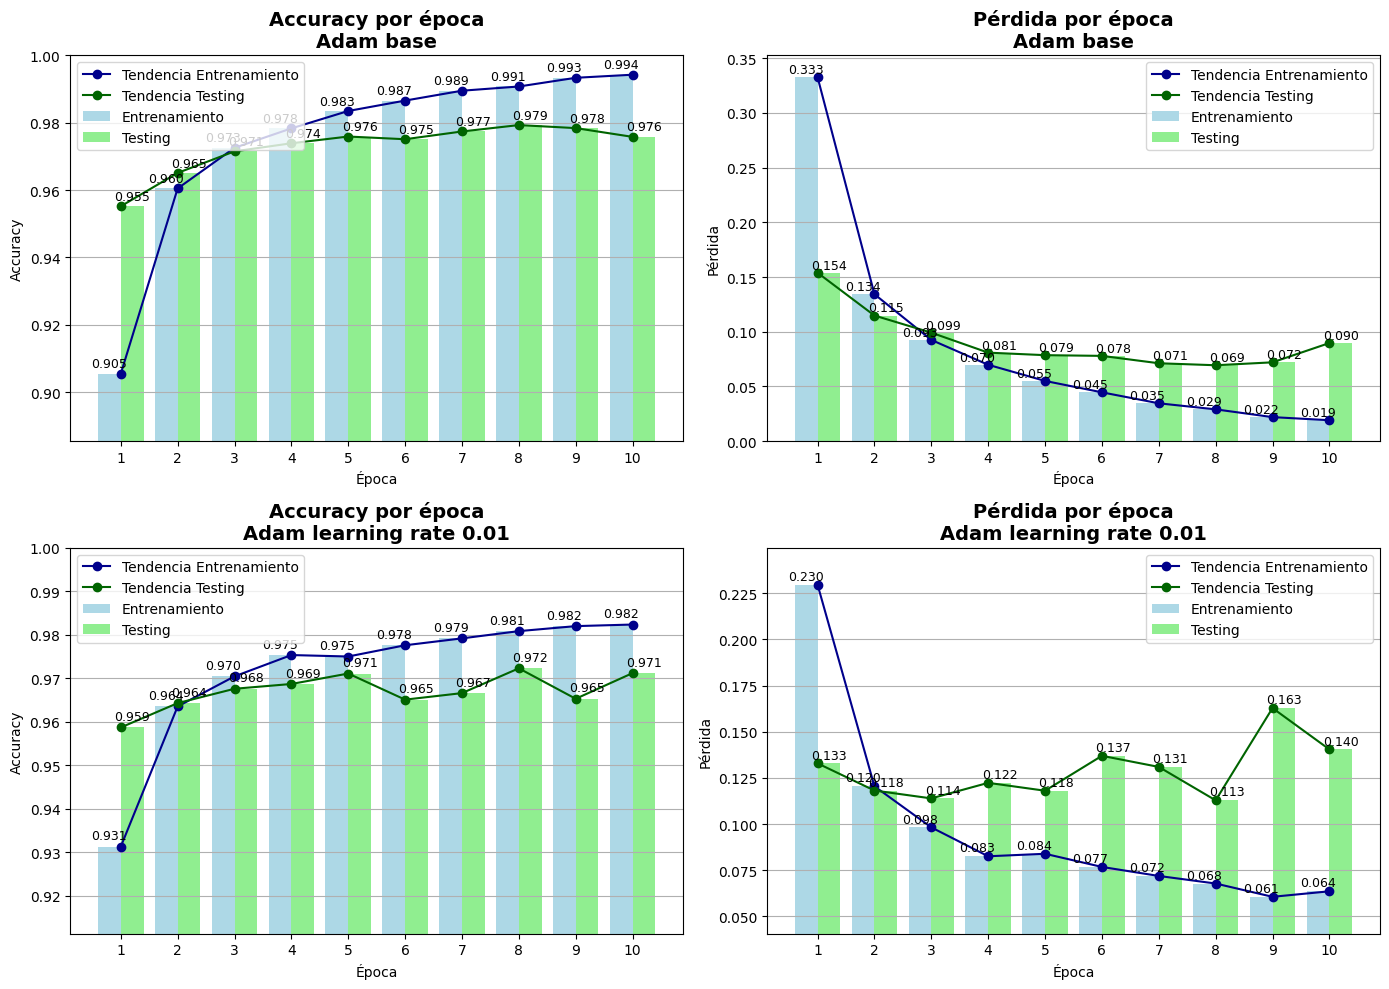

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_adam
plot_accuracy_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 0])
plot_loss_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 1])

# Segundo modelo: hist_adam_act
plot_accuracy_bars(hist_adam_learn, sub_titulo="Adam learning rate 0.01", ax=axes[1, 0])
plot_loss_bars(hist_adam_learn, sub_titulo="Adam learning rate 0.01", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Se observa una mejora constante en el "acuracy" durante las primeras épocas, estabilizándose a partir de la época 4, con una diferencia más pronunciada entre el "accuracy" de entrenamiento y validación en comparación con el modelo anterior. En cuanto a la pérdida, aunque sigue disminuyendo de forma constante, muestra mayores variaciones que el modelo previo, y la diferencia entre las pérdidas de entrenamiento y validación es más significativa. Esto sugiere que, a pesar de la estabilidad en la precisión, el modelo presenta un comportamiento algo más inestable en la reducción de la pérdida en comparación con el anterior.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [57]:
generate_metrics_table_from_histories([hist_adam,hist_adam_learn])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.019201,0.994250,0.994876,0.993533,0.994237,0.089698,0.9758,0.976462,0.9749,0.975603
1,MLP_adam_learn,0.063542,0.982367,0.984391,0.980700,0.982233,0.140421,0.9712,0.974076,0.9694,0.970971


### Tiempo de ejecución comparado con el mejor modelo anterior

In [58]:
print(f"Tiempo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Tiempo de ejecución (segundos) MLP_adam_learn: {time_adam_learn}")
print(f"Diferencia tiempo de ejecución (%): {(time_adam - time_adam_learn)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_adam: 12.586117267608643
Tiempo de ejecución (segundos) MLP_adam_learn: 12.920849561691284
Diferencia tiempo de ejecución (%): -2.83%


### Evaluación learning rate

En esta ocasión, no se implementará el ajuste del learning rate, ya que se observa una disminución en todas las métricas de desempeño, junto con un aumento en la pérdida. Además, la diferencia entre el accuracy de entrenamiento y validación es considerable en comparación con el modelo base, lo que indica un mayor sobre entrenamiento que en el modelo base.

## Aumento de capas

Se aumentó la profundidad del modelo base con optimizador Adam a 4 capas ocultas, manteniendo el learning rate por defecto. Esta modificación busca evaluar cómo incide una mayor complejidad en la arquitectura sobre el rendimiento del modelo.

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [59]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_layers = keras.Sequential(name="MLP_adam_layers")
red_adam_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_adam_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_layers.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [60]:
time_start = time.time()

hist_adam_layers = red_adam_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_layers = time.time() - time_start

hist_adam_layers.name = red_adam_layers.name
hist_models_adam.append(hist_adam_layers)


red_adam_layers.save("./models/red_adam_layers.keras")

### Gráficos de barra con métricas

Visualización de la precisión y perdida por época de los modelos

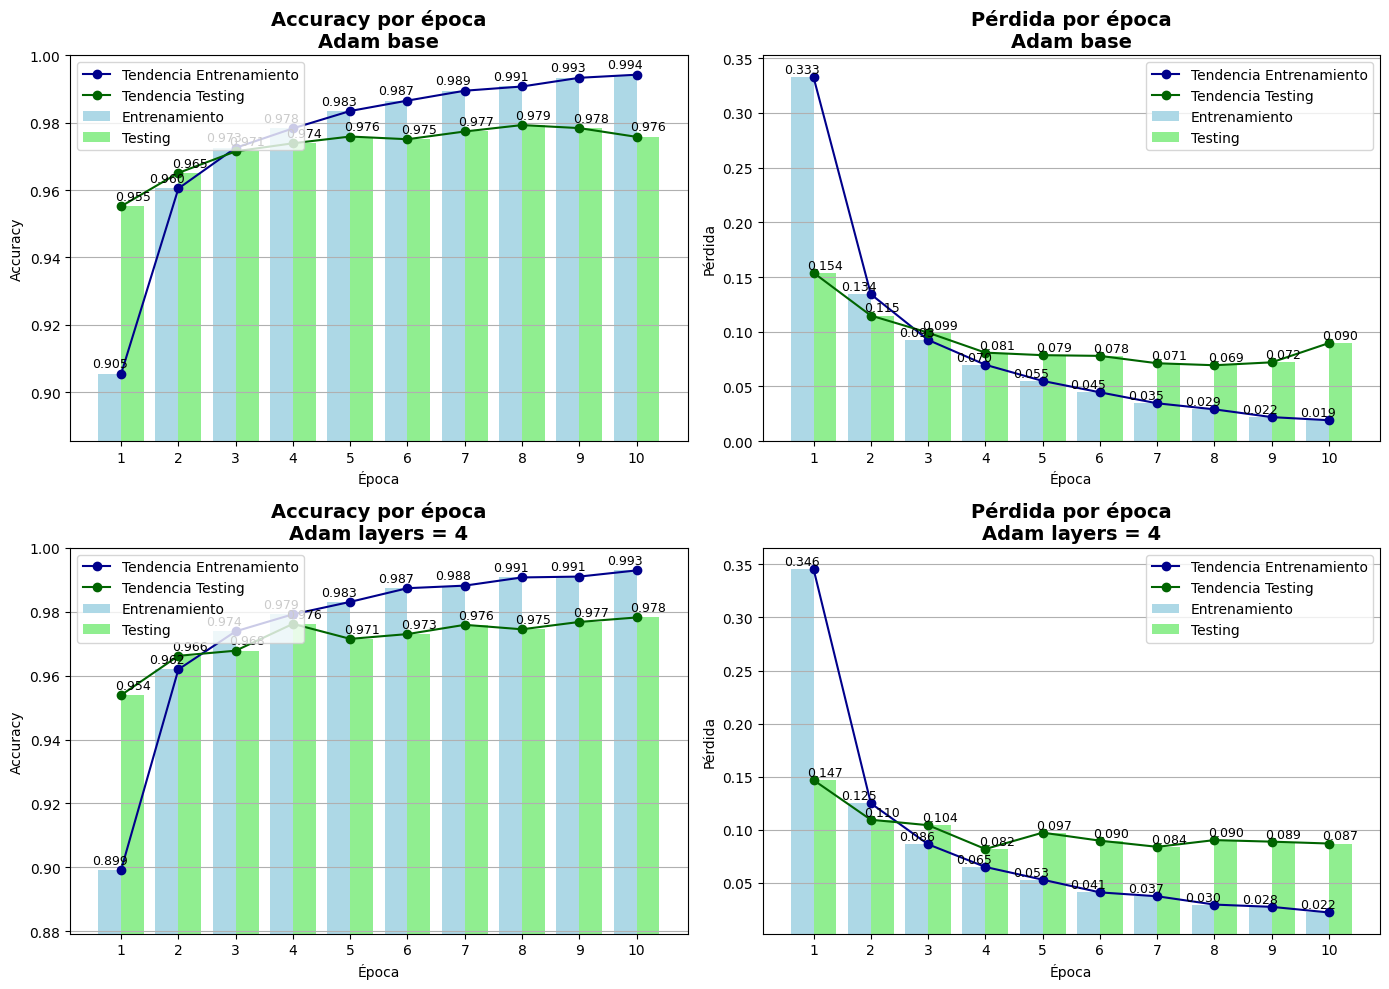

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_adam
plot_accuracy_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 0])
plot_loss_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 1])

# Segundo modelo: hist_adam_act
plot_accuracy_bars(hist_adam_layers, sub_titulo="Adam layers = 4", ax=axes[1, 0])
plot_loss_bars(hist_adam_layers, sub_titulo="Adam layers = 4", ax=axes[1, 1])

plt.tight_layout()
plt.show()

La exactitud del modelo muestra una mejora constante a lo largo de las primeras épocas, estabilizándose a partir de la época 5 en el conjunto de entrenamiento. Desde ese punto, los valores de "accuracy" no presentan grandes variaciones. La diferencia entre las pérdidas de entrenamiento y validación es mayor, lo que sugiere un aprendizaje más lento en las capas agregadas en comparación con el modelo base.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [62]:
generate_metrics_table_from_histories([hist_adam,hist_adam_layers])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.019201,0.994250,0.994876,0.993533,0.994237,0.089698,0.9758,0.976462,0.9749,0.975603
1,MLP_adam_layers,0.022215,0.992933,0.993327,0.992400,0.992890,0.087131,0.9782,0.979054,0.9769,0.977989


### Tiempo de ejecución comparado con el mejor modelo anterior

In [63]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Timepo de ejecución (segundos) MLP_adam_layers: {time_adam_layers}")
print(f"Diferencia tiempo de ejecución (%): {(time_adam - time_adam_layers)/time_sgd*100:.2f}%")

Timepo de ejecución (segundos) MLP_adam: 12.586117267608643
Timepo de ejecución (segundos) MLP_adam_layers: 14.174389600753784
Diferencia tiempo de ejecución (%): -13.42%


### Evaluación aumento de capas

Aunque el "accuracy" se mantiene similar, al aumentar el número de capas también aumenta la pérdida, lo que puede deberse a que el modelo se vuelve más difícil de entrenar. Además, las demás métricas no mejoran mucho, por lo que no vale la pena hacer el modelo más complejo.

## Funciones de activación

Se modificó la función de activación del modelo base con optimizador Adam, reemplazando ReLU por tanh en las capas ocultas. No se aplicó aumento en la cantidad de capas, manteniéndose la estructura original. Esta variante permite analizar el impacto de la activación sobre el desempeño del modelo.

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [64]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam_act = keras.Sequential(name="MLP_adam_act")
red_adam_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_act.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [65]:
time_start = time.time()

hist_adam_act = red_adam_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_act = time.time() - time_start

hist_adam_act.name = red_adam_act.name
hist_models_adam.append(hist_adam_act)

red_adam_act.save("./models/red_adam_act.keras")

### Gráficos de barra con métricas

Visualización de la precisión y perdida por época de los modelos

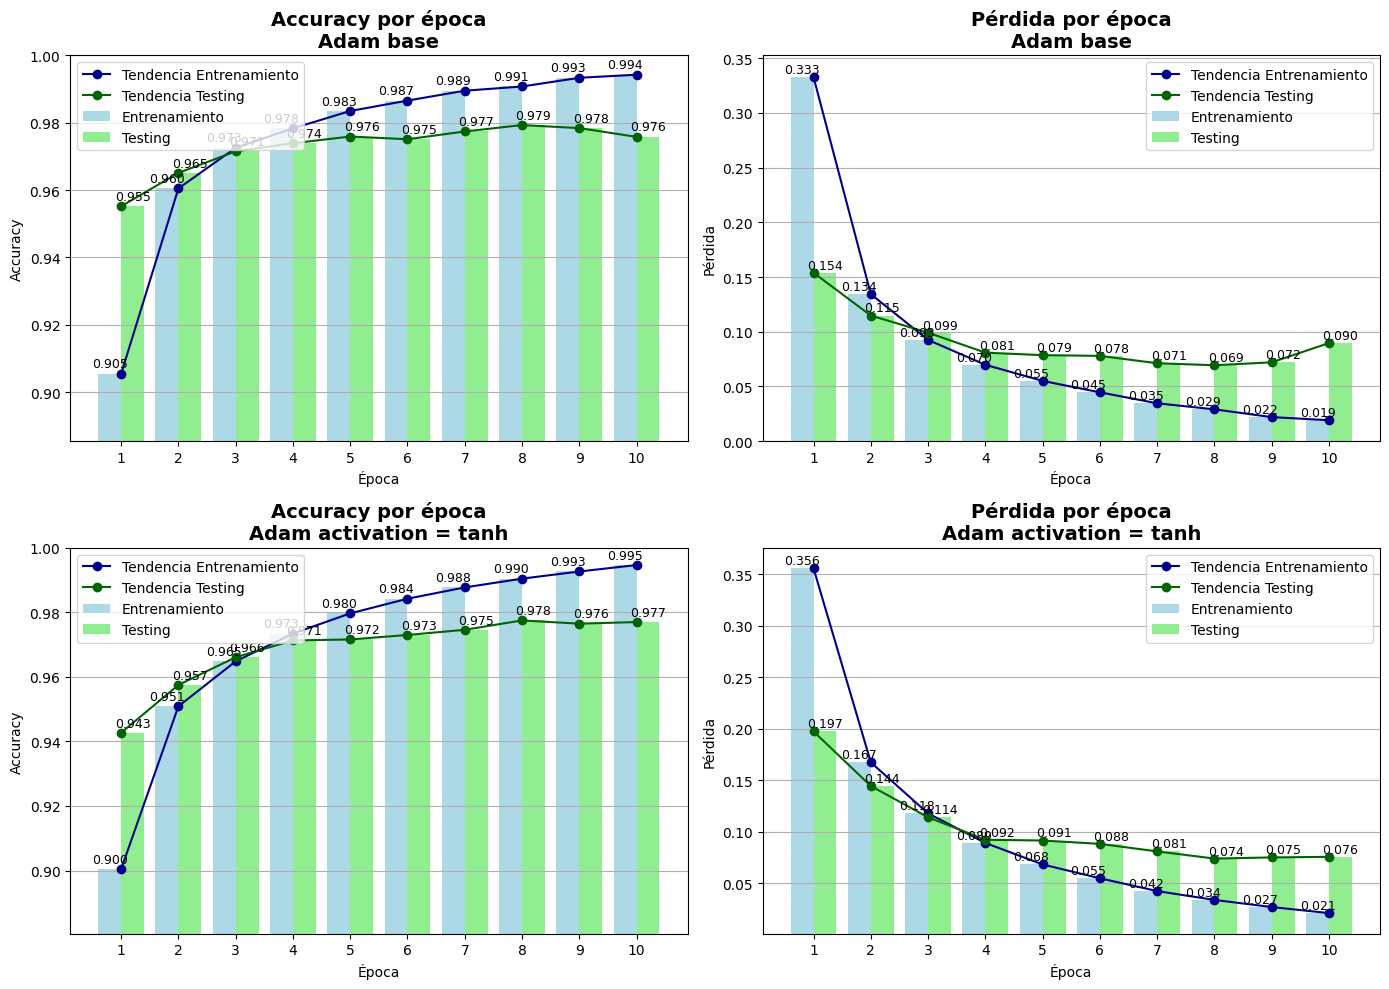

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_adam
plot_accuracy_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 0])
plot_loss_bars(hist_adam, sub_titulo="Adam base", ax=axes[0, 1])

# Segundo modelo: hist_adam_act
plot_accuracy_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[1, 0])
plot_loss_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[1, 1])

plt.tight_layout()
plt.show()

A lo largo de las primeras épocas, la "accuracy" del modelo va incrementando de forma consistente en el conjunto de entrenamiento. Después de este aumento inicial, los valores se mantienen relativamente constantes. En cuanto a la pérdida, con la función de activación "tanh", se observa una disminución respecto al modelo base, y la diferencia entre las pérdidas de entrenamiento y validación es menor, lo que sugiere un aprendizaje más equilibrado y estable.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [67]:
generate_metrics_table_from_histories([hist_adam,hist_adam_act])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.019201,0.994250,0.994876,0.993533,0.994237,0.089698,0.9758,0.976462,0.9749,0.975603
1,MLP_adam_act,0.020992,0.994667,0.995591,0.993667,0.994672,0.075603,0.9770,0.979420,0.9756,0.976803


### Tiempo de ejecución comparado con el mejor modelo anterior

In [68]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Timepo de ejecución (segundos) MLP_adam_act: {time_adam_act}")
print(f"Diferencia tiempo de ejecución (%): {(time_adam - time_adam_act)/time_sgd*100:.2f}%")

Timepo de ejecución (segundos) MLP_adam: 12.586117267608643
Timepo de ejecución (segundos) MLP_adam_act: 13.458155632019043
Diferencia tiempo de ejecución (%): -7.37%


### Evaluación función de activación

La diferencia no es enorme, pero la función de activación en MLP_adam_act está ayudando a mejorar tanto las métricas en el conjunto de entrenamiento como en el conjunto de validación, lo que sugiere que el modelo con activación podría estar generalizando mejor, debido a esto el resto de pruebas se realizara con la función de activación tanh.

## Tamaño del batch

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [69]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_batch = keras.Sequential(name="MLP_adam_batch_tahn")
red_adam_batch.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_batch.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_batch.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [70]:
time_start = time.time()
hist_adam_batch = red_adam_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_batch = time.time() - time_start

hist_adam_batch.name = red_adam_batch.name
hist_models_adam.append(hist_adam_batch)


red_adam_batch.save("./models/red_adam_batch.keras")


### Gráficos de barra con métricas

Visualización de la precisión y perdida por época de los modelos

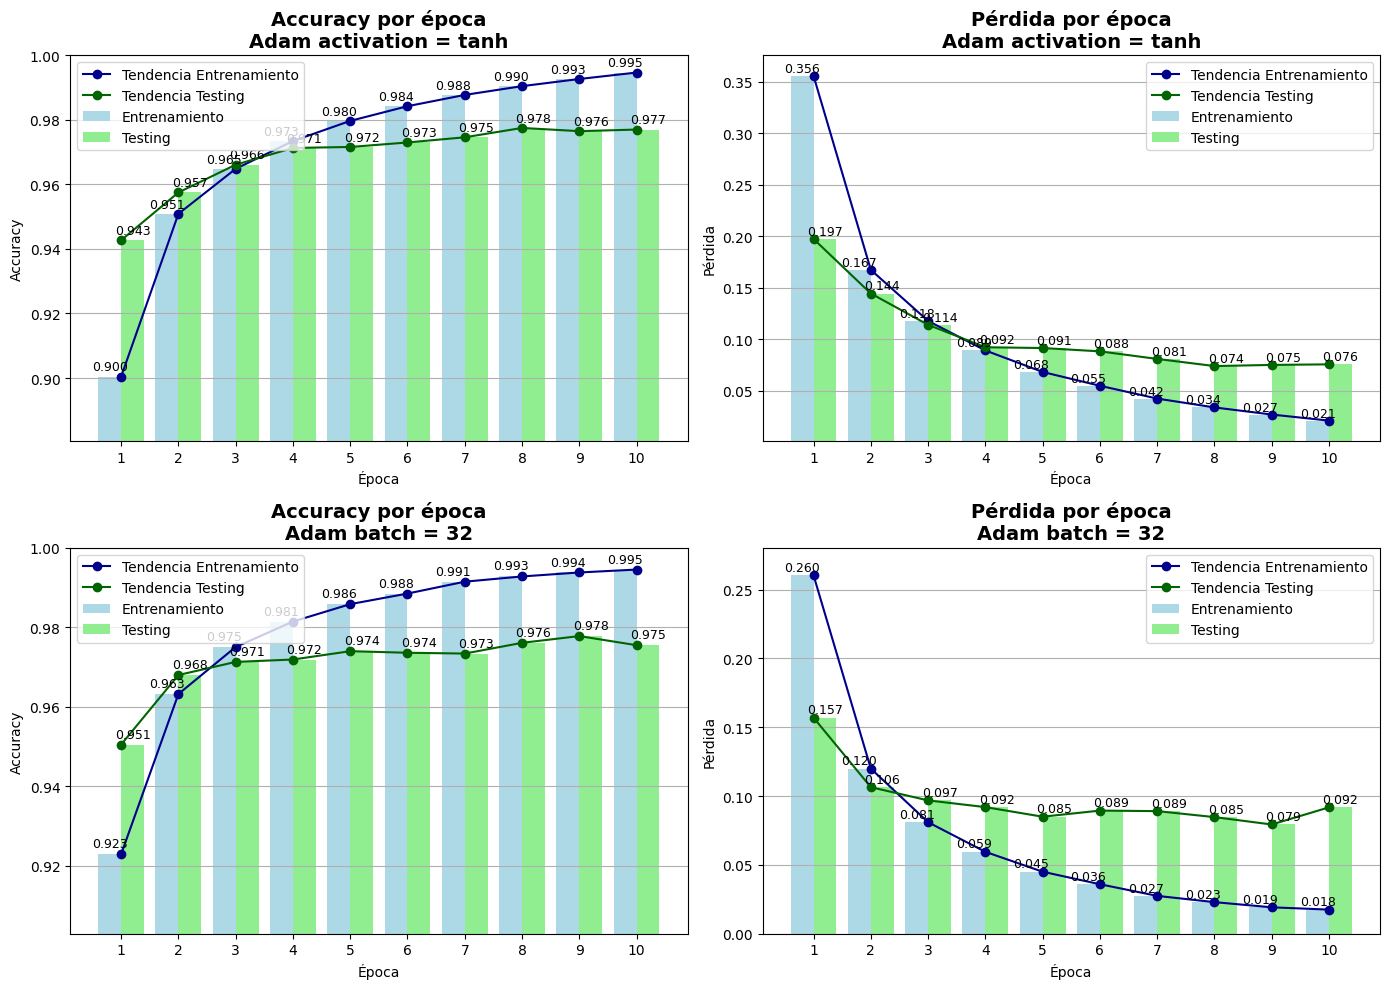

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_adam
plot_accuracy_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[0, 0])
plot_loss_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[0, 1])

# Segundo modelo: hist_adam_act
plot_accuracy_bars(hist_adam_batch, sub_titulo="Adam batch = 32", ax=axes[1, 0])
plot_loss_bars(hist_adam_batch, sub_titulo="Adam batch = 32", ax=axes[1, 1])

plt.tight_layout()
plt.show()

La "accuracy" se mantiene similar a la versión anterior con "tanh", pero se observa un aumento en la pérdida y una mayor diferencia entre los conjuntos de entrenamiento y prueba en esta versión con batch size de 32.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [72]:
generate_metrics_table_from_histories([hist_adam_act, hist_adam_batch])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam_act,0.020992,0.994667,0.995591,0.993667,0.994672,0.075603,0.9770,0.979420,0.9756,0.976803
1,MLP_adam_batch_tahn,0.017515,0.994533,0.995062,0.994133,0.994508,0.091841,0.9755,0.976646,0.9744,0.975293


### Tiempo de ejecución comparado con el mejor modelo anterior

In [73]:
print(f"Timepo de ejecución (segundos) MLP_adam_act: {time_adam_act}")
print(f"Timepo de ejecución (segundos) MLP_adam_batch_tahn: {time_adam_batch}")
print(f"Diferencia tiempo de ejecución (%): {(time_adam_act - time_adam_batch)/time_sgd*100:.2f}%")

Timepo de ejecución (segundos) MLP_adam_act: 13.458155632019043
Timepo de ejecución (segundos) MLP_adam_batch_tahn: 38.65363311767578
Diferencia tiempo de ejecución (%): -212.96%


### Evaluación batch

Se puede observar que ambas alternativas tienen un accuracy similar, sin embargo, hay un aumento en la perdida de la versión de batch, el resto de metricas son similares. La principal diferencia en estos modelos además de la perdida es el tiempo de ejecución, cual aumenta aproximadamente el doble, debido a estas razones no se utilizara la reducción de batch para el resto del notebook

## Dropout

### Creación y ejecución de modelo

Creación del modelo con su arquitectura

In [74]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam_drop = keras.Sequential(name="MLP_adam_drop_tanh")
red_adam_drop.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_drop.add(keras.layers.Dropout(0.3))
red_adam_drop.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_drop.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Ejecución y guardado del modelo

In [75]:
time_start = time.time()
hist_adam_drop = red_adam_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_drop = time.time() - time_start

hist_adam_drop.name = red_adam_drop.name
hist_models_adam.append(hist_adam_drop)


red_adam_drop.save("./models/red_adam_drop.keras")

### Gráficos de barra con métricas

Visualización de la precisión y perdida por época de los modelos

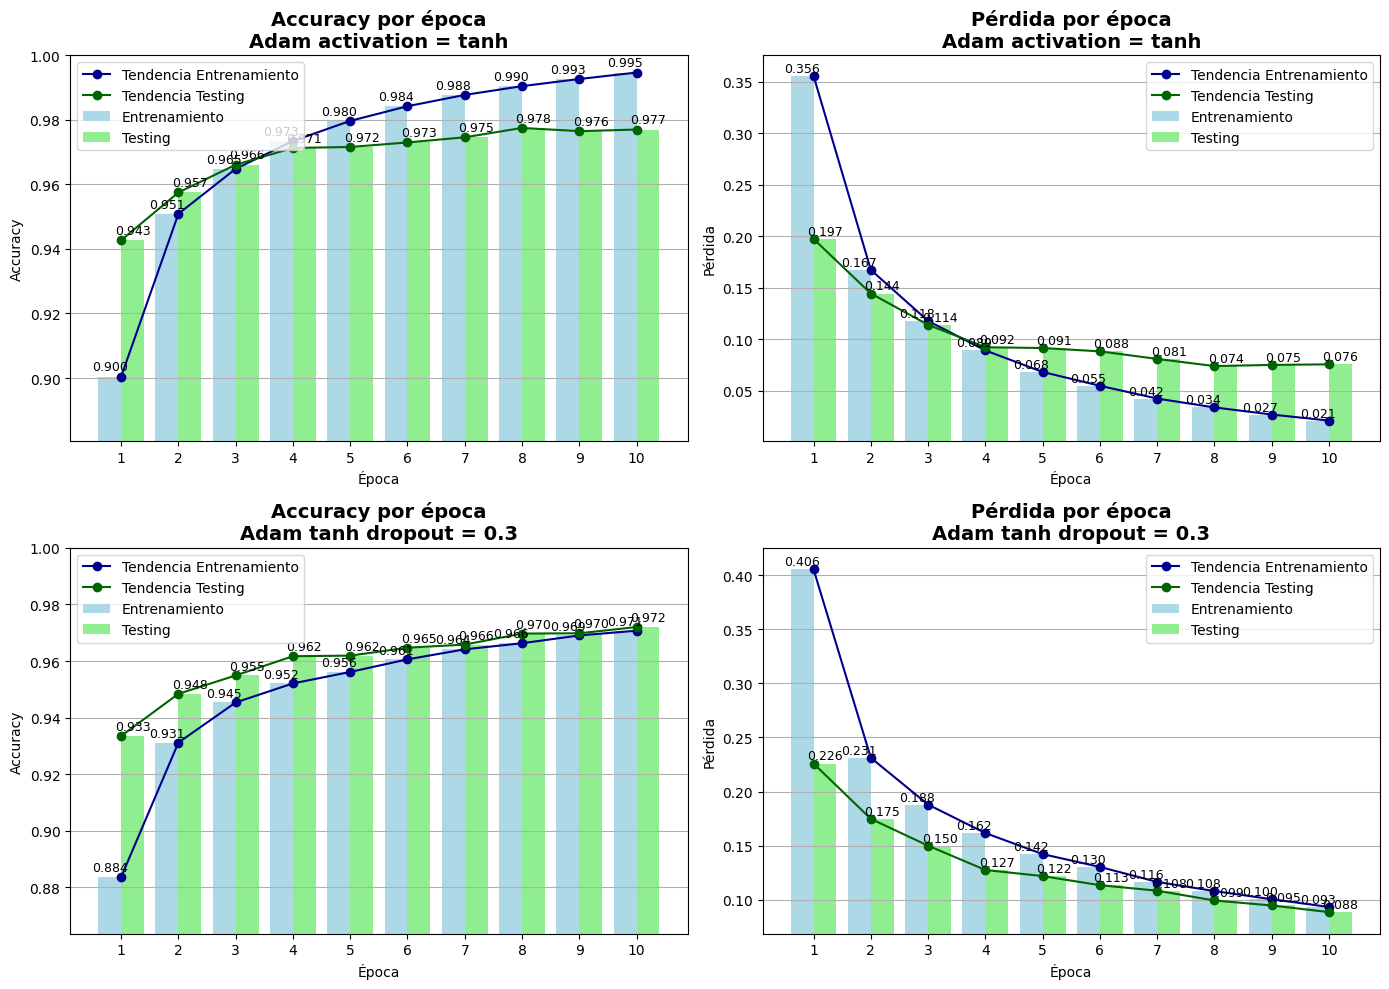

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: 
plot_accuracy_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[0, 0])
plot_loss_bars(hist_adam_act, sub_titulo="Adam activation = tanh", ax=axes[0, 1])

# Segundo modelo: 
plot_accuracy_bars(hist_adam_drop, sub_titulo="Adam tanh dropout = 0.3", ax=axes[1, 0])
plot_loss_bars(hist_adam_drop, sub_titulo="Adam tanh dropout = 0.3", ax=axes[1, 1])

plt.tight_layout()
plt.show()

La aplicación de dropout muestra un aprendizaje más estable y una mejor generalización. La diferencia en la "accuracy" y la pérdida entre los conjuntos de entrenamiento y prueba es menor lo que valida esto.

### Tabla con métricas

Esta tabla incluye todas de las métricas tanto para entrenamiento como para testing

In [77]:
generate_metrics_table_from_histories([hist_adam_act,hist_adam_drop])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam_act,0.020992,0.994667,0.995591,0.993667,0.994672,0.075603,0.977,0.979420,0.9756,0.976803
1,MLP_adam_drop_tanh,0.093125,0.970717,0.976094,0.967017,0.970414,0.088383,0.972,0.975754,0.9699,0.971815


### Tiempo de ejecución comparado con el mejor modelo anterior

In [78]:
print(f"Timepo de ejecución (segundos) MLP_adam_act: {time_adam_act}")
print(f"Timepo de ejecución (segundos) MLP_adam_drop_tanh: {time_adam_drop}")
print(f"Diferencia tiempo de ejecución (%): {(time_adam_act - time_adam_drop)/time_sgd*100:.2f}%")

Timepo de ejecución (segundos) MLP_adam_act: 13.458155632019043
Timepo de ejecución (segundos) MLP_adam_drop_tanh: 21.734092950820923
Diferencia tiempo de ejecución (%): -69.95%


### Evaluación DropOut

A pesar de que el modelo con la función de activación tanh muestra métricas ligeramente superiores, el modelo con dropout presenta una menor diferencia entre entrenamiento y validación, lo que indica una mejor capacidad de generalización y menor sobreajuste. Dado que sus métricas son similares y ofrece un comportamiento más estable, se optará por utilizar el modelo con dropout.

# Elección del mejor modelo:

## Gráficos y tablas con métricas

### Gráficos de barra con métricas

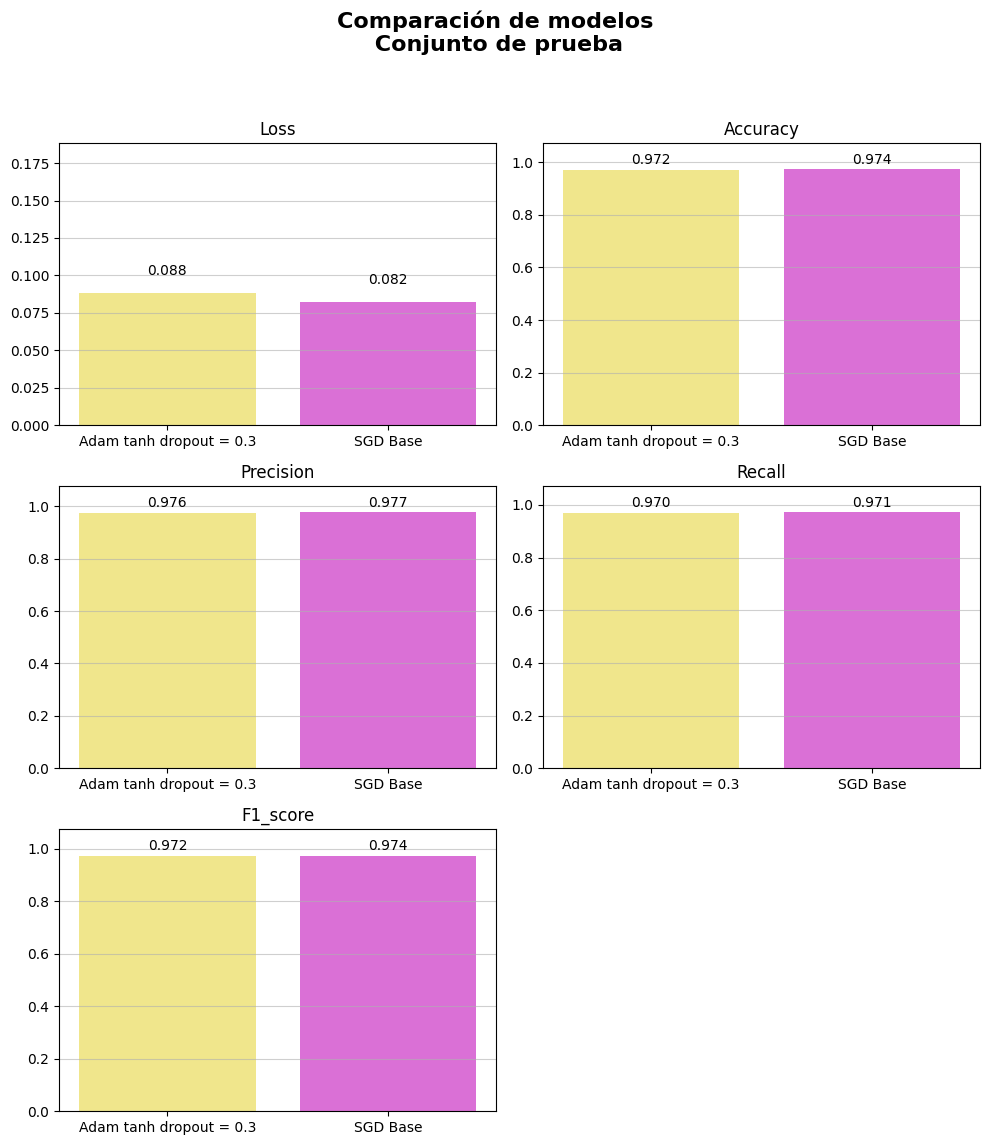

In [79]:
compare_history_metrics_grid(hist_adam_drop, hist_sgd, "Adam tanh dropout = 0.3", "SGD Base", title="Comparación de modelos\n Conjunto de prueba")

Es importante destacar que, en el caso de las métricas de precisión, recall y F1-score, los valores reportados para ambos modelos corresponden al promedio simple calculado entre todas las clases. No se observa una variación significativa en estas métricas entre los modelos comparados. 

### Tabla con todas las métricas (Conjunto de entrenamiento y prueba)

In [80]:
generate_metrics_table_from_histories([hist_sgd, hist_adam_drop])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.053072,0.984800,0.987849,0.982317,0.984742,0.082208,0.9739,0.977353,0.9710,0.973623
1,MLP_adam_drop_tanh,0.093125,0.970717,0.976094,0.967017,0.970414,0.088383,0.9720,0.975754,0.9699,0.971815


### Resumen de los hiper-parámetros de cada modelo

In [81]:
tabla = extraer_info_redes(['red_sgd', 'red_adam_drop'])
tabla

,Nombre Red,Función de Activación,Tasa de Dropout,Optimizador,Learning Rate
0,MLP_sgd,relu,0.0,SGD,0.010
1,MLP_adam_drop_tanh,tanh,0.3,Adam,0.001


In [82]:
print(f"Tiempo de ejecución (segundos) MLP_sgd: {time_sgd}")
print(f"Tiempo de ejecución (segundos) MLP_adam_drop: {time_adam_drop}")
print(f"Porcentaje de mejora/empeoramiento: {(time_sgd - time_adam_drop)/time_sgd*100:.2f}%")

Tiempo de ejecución (segundos) MLP_sgd: 11.831286907196045
Tiempo de ejecución (segundos) MLP_adam_drop: 21.734092950820923
Porcentaje de mejora/empeoramiento: -83.70%


El tiempo de entrenamiento del modelo con optimizador SGD es menor que el del modelo con ADAM, lo cual puede representar un factor relevante a considerar en la selección del modelo final.

## Justificación de elección

Se optó por utilizar el modelo "SGD + Momentum" como modelo final, ya que presentó un rendimiento ligeramente superior en todas las métricas evaluadas. No obstante, es importante destacar que ambos modelos muestran un desempeño bastante bueno, y que, debido a las diferencias mínimas entre sus resultados, su comportamiento en la práctica debería ser prácticamente equivalentes.

## Resumen de la arquitectura del mejor modelo

In [83]:
red_sgd.summary()

Model: "MLP_sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera_capa (Dense)        (None, 128)               100480    
                                                                 
 segunda_capa (Dense)        (None, 64)                8256      
                                                                 
 capa_de_salida (Dense)      (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Para la primera capa: $100480 = 28 * 28 * 128 + 128$
- Para la segunda capa: $8256 = 64 * 128 + 64$
- Para la capa de salida: $650 = 64 * 10 + 10$

# Carga, evaluación y predicción de un modelo

## Descarga de archivos necesarios

In [90]:
if (os.path.exists("train-images-idx3-ubyte.gz") and os.path.exists("train-labels-idx1-ubyte.gz") and os.path.exists("t10k-images-idx3-ubyte.gz") and os.path.exists("t10k-labels-idx1-ubyte.gz")):
    print("Datasets already downloaded")
else:
    !rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz

Datasets already downloaded


In [93]:
!rm -f red_sgd.keras saved_image.npy
for i in range(10):
    !rm -f {i}.png

!wget https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/refs/heads/main/red_sgd.keras
!wget https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/refs/heads/main/saved_image.npy
for i in range(10):
    !wget https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/refs/heads/main/images/{i}.png

--2025-04-21 02:56:45--  https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/refs/heads/main/red_sgd.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908030 (887K) [application/octet-stream]
Saving to: ‘red_sgd.keras’

red_sgd.keras       100%[===================>] 886.75K  --.-KB/s    in 0.02s   

2025-04-21 02:56:45 (38.5 MB/s) - ‘red_sgd.keras’ saved [908030/908030]

--2025-04-21 02:56:46--  https://raw.githubusercontent.com/JuanZweifel/deep-learning-2025/refs/heads/main/saved_image.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting re

In [85]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


## SDG + Momentum

In [86]:
# Evaluar modelo
loaded_model = load_model('red_sgd.keras')

results = loaded_model.evaluate(X_test, y_test)

print("Test results:")
for metric_name, result in zip(loaded_model.metrics_names, results):
    print(f"{metric_name}: {result}")

# Con dibujo propio (Este fue generado por la "app" de dibujo. El dibujo es un 4)
img_array = np.load("./saved_image.npy")

prediction = loaded_model.predict(img_array)
print("\nPrediccion con Data propia:")
print(int(np.argmax(prediction)))

313/313 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9750 - precision: 0.9786 - recall: 0.9719 - f1_score: 0.9748
Test results:
loss: 0.08168134093284607
accuracy: 0.9750000238418579
precision: 0.9785541892051697
recall: 0.9718999862670898
f1_score: [0.9817258  0.9864094  0.97762644 0.9743589  0.97096276 0.97209823
 0.9775222  0.973236   0.9668394  0.9671969 ]
1/1 [==============================] - 0s 77ms/step

Prediccion con Data propia:
4


## Prueba con números dibujados a mano

1/1 [==============================] - 0s 12ms/step


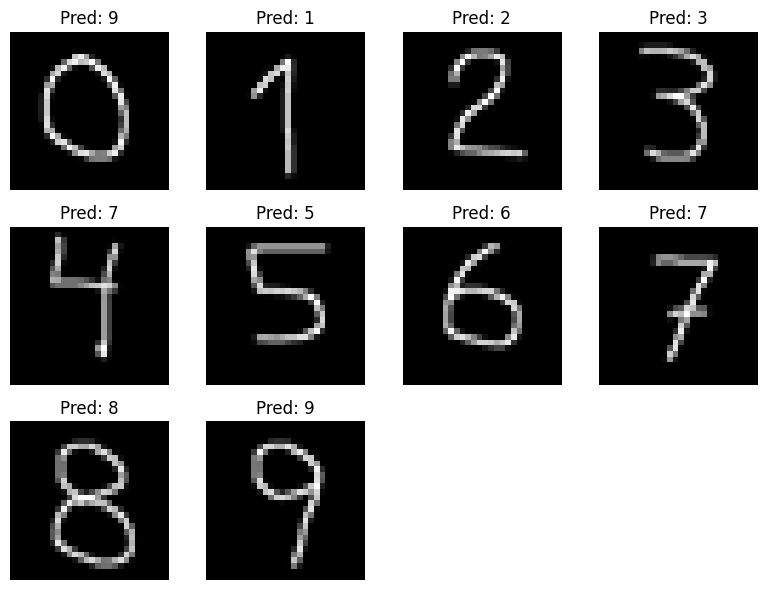

In [87]:
import numpy as np
from PIL import Image

def preprocess_image(filepath):
    img = Image.open(filepath).convert('L')
    img = img.resize((28, 28)).copy()
    img_array = np.array(img)
    img_array = img_array.astype("float32") / 255.0
    img_array = img_array.reshape(1, 28 * 28)
    return img_array, img

image_data = []
predictions = []
for i in range(10):
    img_array, img = preprocess_image(f"{i}.png")
    prediction = loaded_model.predict(img_array)
    image_data.append((img_array.reshape(28, 28), int(np.argmax(prediction))))

h = 3 
w = 4 
fig, axs = plt.subplots(h, w, figsize=(2*w, 2*h))

index = 0
for i in range(h):
    for j in range(w):
        if index < len(image_data):
            img, pred = image_data[index]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].set_title(f"Pred: {pred}")
            axs[i, j].axis('off')  
            index += 1
        else:
            axs[i, j].axis('off')  

plt.tight_layout()
plt.show()

# Conclusión:

En base a las pruebas realizadas y la evaluación de diversas configuraciones, se seleccionó el modelo "SGD + Momentum" como el modelo final, dado que mostró un rendimiento ligeramente superior en las métricas clave, como la "accuracy" y la pérdida, en comparación con otros modelos evaluados. Sin embargo, es importante resaltar que ambos modelos presentaron resultados muy similares, lo que indica que, aunque se observa una leve diferencia, el rendimiento en la práctica sería prácticamente equivalente. En consecuencia, la elección del modelo final no solo se basa en las métricas obtenidas, sino también en la simplicidad y eficiencia que "SGD + Momentum" ofrece, lo que lo convierte en una opción sólida para la tarea de clasificación en este caso específico.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9dc7e3b2-3914-4a2d-83b3-47dbec5af292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>